<a href="https://colab.research.google.com/github/imnawar/CS664_Project/blob/main/CDM_for_Improved_ER_Using_FER2013_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class-Conditional Diffusion Models for Improved Emotion Recognition Using FER2013


---


Manal Allahyani

Rahaf Alsulami

Renad Alsaidi


---

**King Abdulaziz University**

**Faculty of Computing and Information Systems**

**Spring 2025**


---


***CS664-Computer Vision***

**Course Project**

# Set the enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install opendatasets

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
! pip install torch-fidelity

In [4]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00


In [5]:
!pip install torch torchvision scikit-learn

In [6]:
!pip install -q kaggle

In [7]:
# === Standard Libraries ===
import os
import json
import copy
import random
import shutil
import zipfile
from pathlib import Path

# === Numerical & Scientific Libraries ===
import numpy as np
from scipy import linalg
from scipy.linalg import sqrtm

# === Image Processing ===
from PIL import Image, ImageStat
from skimage import filters

# === Plotting & Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Progress Bar ===
from tqdm import tqdm

# === PyTorch Core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


# === Torchvision ===
from torchvision import datasets, transforms, models
from torchvision.models import inception_v3
from torchvision.transforms import RandomApply

# === TorchMetrics ===
import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# === Diffusers (for diffusion models) ===
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from huggingface_hub import hf_hub_download
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Union

# === Evaluation Metrics ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === OpenDatasets (Kaggle datasets etc.) ===
import opendatasets as od

# === LPIPS Metric ===
import lpips


In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Download the dataset

In [9]:
# Data to be written
dictionary = {"username":"imanawar","key":"8a39e9fa45fc2924d031f36a89e8879d"}

with open("kaggle.json", "w") as outfile:
	json.dump(dictionary, outfile)

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d 'msambare/fer2013'

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.24GB/s]


In [13]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    '''Extracts zipfile'''

    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
            print("Extracting files...")
            zip_ref.extractall(destination_path)
            print("Extracting finished.")
    else:
        print("Data already extracted.")

data_path = Path("/content")
zipfile_path = data_path / "fer2013.zip"
images_path = data_path / "fer2013"

extract_data(zipfile_path, images_path)


/content/fer2013 doesn't exist, creating one...
Extracting files...
Extracting finished.


In [14]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("fer2013/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images

📈 Visual Representation:
angry   : ███████████████████████████ 3995
disgust : ███ 436
fear    : ████████████████████████████ 4097
happy   : ██████████████████████████████████████████████████ 7215
sad     : █████████████████████████████████ 4830
surprise: █████████████████████ 3171
neutral : ██████████████████████████████████ 4965


In [15]:
def show_emotion_grid(base_path="fer2013/train", emotions=None, images_per_class=2, image_size=(48, 48)):
    if emotions is None:
        emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    fig, axs = plt.subplots(images_per_class, len(emotions), figsize=(len(emotions) * 1.5, images_per_class * 1.5))

    for col, emotion in enumerate(emotions):
        class_path = os.path.join(base_path, emotion)
        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        chosen_files = random.sample(files, images_per_class)

        for row in range(images_per_class):
            img_path = os.path.join(class_path, chosen_files[row])
            img = Image.open(img_path).convert('L').resize(image_size)
            axs[row, col].imshow(img, cmap='gray')
            axs[row, col].axis('off')

    # Add labels above each column
    for col, emotion in enumerate(emotions):
        axs[0, col].set_title(emotion.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()


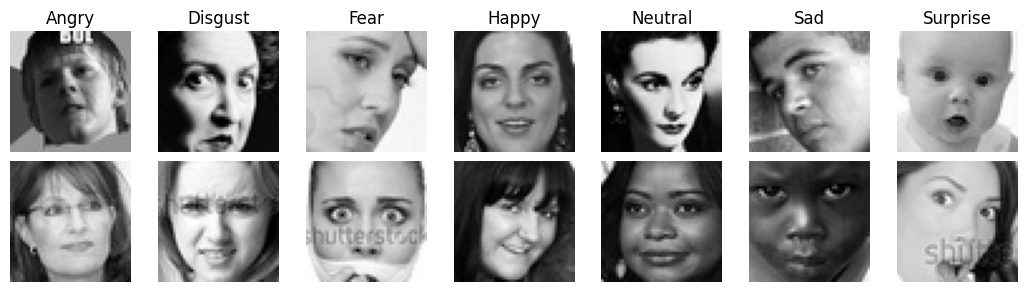

In [16]:
show_emotion_grid("fer2013/train")

# Diffusion Model For Generating Data

In [17]:
# Define a new diffusion pipeline class that extends DiffusionPipeline
class DDPMPipelinenew(DiffusionPipeline):
    def __init__(self, unet, scheduler, num_classes: int):
        super().__init__()
        self.register_modules(unet=unet, scheduler=scheduler)  # Register modules with pipeline
        self.num_classes = num_classes                         # Store number of emotion classes
        self._device = unet.device                             # Set device based on UNet model

    @torch.no_grad()  # Disable gradient calculation for inference
    def __call__(
        self,
        batch_size: int = 64,
        class_labels: Optional[torch.Tensor] = None,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:

        # Ensure class labels are on the correct device
        class_labels = class_labels.to(self._device)

        # Expand class labels to match the batch size
        if class_labels.ndim == 0:
            class_labels = class_labels.unsqueeze(0).expand(batch_size)
        else:
            class_labels = class_labels.expand(batch_size)

        # Determine the shape of the image tensor to generate
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        # Create a random noise tensor as the starting point for generation
        image = randn_tensor(image_shape, generator=generator, device=self._device)

        # Set the scheduler timesteps (e.g., 1000 denoising steps)
        self.scheduler.set_timesteps(num_inference_steps)

        # Iteratively denoise the image through the reverse diffusion process
        for t in self.progress_bar(self.scheduler.timesteps):
            # Get model prediction given current image, timestep t, and class label
            model_output = self.unet(image, t, class_labels).sample
            # Update image based on scheduler step
            image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

        # Post-process image: normalize pixel values to [0,1] and convert to numpy
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # Convert output to PIL format if specified
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        # Return results as a tuple or dictionary
        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

    # Move the entire pipeline to a specified device
    def to(self, device: torch.device):
        self._device = device
        self.unet.to(device)
        return self

# Utility function to load a pretrained diffusion pipeline
def load_pipeline(repo_id, num_classes, device):
    unet = UNet2DModel.from_pretrained(repo_id, subfolder="unet").to(device)
    scheduler = DDPMScheduler.from_pretrained(repo_id, subfolder="scheduler")
    pipeline = DDPMPipelinenew(unet=unet, scheduler=scheduler, num_classes=num_classes)
    return pipeline.to(device)

# Utility function to save generated images to local directory
def save_images_locally(images, save_dir, epoch, class_label, start_idx=0):
    os.makedirs(save_dir, exist_ok=True)  # Create directory if not exists
    for i, image in enumerate(images):
        idx = start_idx + i
        image_path = os.path.join(save_dir, f"image_epoch{epoch}_class{class_label}_idx{idx}.png")
        image.save(image_path)

# Generate synthetic images for a specific emotion class and save them
def generate_images(pipeline, class_label, batch_size, num_images, num_inference_steps, save_dir, epoch):
    total_generated = 0
    while total_generated < num_images:
        # Determine the number of images to generate in this batch
        current_batch_size = min(batch_size, num_images - total_generated)
        # Create a reproducible random generator for consistent sampling
        generator = torch.Generator(device=pipeline._device).manual_seed(total_generated)
        # Create tensor of class labels for the batch
        class_labels = torch.tensor([class_label] * current_batch_size).to(pipeline._device)

        # Generate images using the diffusion pipeline
        images = pipeline(
            generator=generator,
            batch_size=current_batch_size,
            num_inference_steps=num_inference_steps,
            class_labels=class_labels,
            output_type="pil",
        ).images

        # Save generated images to disk
        save_images_locally(images, save_dir, epoch, class_label, start_idx=total_generated)
        total_generated += len(images)


In [ ]:
if __name__ == "__main__":
    # Repository ID of the pretrained conditional diffusion model on Hugging Face
    repo_id = "Ketansomewhere/FER_2013_Conditional_Diffusion"

    # Number of facial expression classes in FER2013 dataset
    num_classes = 7

    # Batch size used for image generation per step
    batch_size = 64

    # Number of denoising steps for the diffusion process
    num_inference_steps = 100

    # Root directory where generated images will be saved
    save_root = "generated_images"

    # Epoch index (can be used for tracking if multiple epochs of generation are performed)
    epoch = 0

    # Mapping from class index to emotion name
    emotion_labels = {
        0: "angry",
        1: "disgust",
        2: "fear",
        3: "happy",
        4: "sad",
        5: "surprise",
        6: "natural"
    }

    # Current image counts for each emotion class in the training set
    current_counts = {
        0: 3995,  # angry
        1: 436,   # disgust
        2: 4097,  # fear
        3: 7215,  # happy (already exceeds target)
        4: 4830,  # sad
        5: 3171,  # surprise
        6: 4965   # neutral
    }

    # Target number of images per class (for class balance)
    target_per_class = 5000

    # Set device to GPU if available, otherwise fallback to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pretrained conditional diffusion pipeline to generate synthetic images
    pipeline = load_pipeline(repo_id, num_classes, device)

    # Iterate through each emotion class
    for class_label in range(num_classes):
        # Determine how many more images are needed to reach the target
        needed = target_per_class - current_counts[class_label]
        if needed <= 0:
            print(f"Class {class_label}: already has {current_counts[class_label]} images.")
            continue  # Skip classes that are already at or above target

        print(f"Generating {needed} images for class {class_label}...")
        emotion_name = emotion_labels[class_label]  # Get emotion name string
        save_dir = os.path.join(save_root, emotion_name)  # Define class-specific save path

        # Generate and save synthetic images for the current class
        generate_images(pipeline, class_label, batch_size, needed, num_inference_steps, save_dir, epoch)

    print("✅ All required images generated.")


Generating 1005 images for class 0...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating 4564 images for class 1...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating 903 images for class 2...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Class 3: already has 7215 images.
Generating 170 images for class 4...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating 1829 images for class 5...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating 35 images for class 6...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ All required images generated.


## Evaluating The Generated Data

***Metrics***

***FID*** : Measures how similar two groups of images are
Lower FID → generated images are closer to real images.
__________________
***IS*** : Measures both image quality and diversity.
Higher IS → images are sharp and diverse.

___________________________
***LPIPS*** :
Measures perceptual similarity between two images from a human vision point of view.
Lower LPIPS is better:

Lower LPIPS → generated images are more visually similar to real images.




In [ ]:
fid_metric = torchmetrics.image.fid.FrechetInceptionDistance(feature=2048).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 92.2MB/s]


In [ ]:
lpips_model = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 211MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

def load_images(folder_path, num_images):
    images = []
    files = sorted(os.listdir(folder_path))[:num_images]
    for file in files:
        img = Image.open(os.path.join(folder_path, file)).convert('RGB')  # Convert to 3 channels
        img = transform(img)
        images.append(img)
    return images

def evaluate_class(class_name, real_base, fake_base, num_images=100):
    print(f"\nEvaluating class: {class_name}")

    real_path = os.path.join(real_base, class_name)
    fake_path = os.path.join(fake_base, class_name)

    real_images = load_images(real_path, num_images)
    fake_images = load_images(fake_path, num_images)

    real_images = torch.stack(real_images).to(device)
    fake_images = torch.stack(fake_images).to(device)

    # 🛠 Fix: Convert to uint8 format for FID
    real_images_uint8 = (real_images).byte()
    fake_images_uint8 = (fake_images).byte()

    with torch.no_grad():
        # FID
        fid_metric.update(real_images_uint8, real=True)
        fid_metric.update(fake_images_uint8, real=False)
        fid_value = fid_metric.compute()
        fid_metric.reset()

        # LPIPS
        lpips_scores = []
        for real_img, fake_img in zip(real_images, fake_images):
            score = lpips_model(real_img.unsqueeze(0), fake_img.unsqueeze(0))
            lpips_scores.append(score.item())
        avg_lpips = sum(lpips_scores) / len(lpips_scores)

    print(f"  - Frechet Inception Distance (FID): {fid_value:.4f}")
    print(f"  - Average LPIPS Score: {avg_lpips:.6f}")


In [ ]:
#pathes
real_base_path = "/content/fer2013/train"
fake_base_path = "/content/generated_images"


classes_to_evaluate = ['angry', 'disgust', 'fear', 'sad', 'surprise', 'neutral']

for class_name in classes_to_evaluate:
    evaluate_class(class_name, real_base=real_base_path, fake_base=fake_base_path, num_images=50)



Evaluating class: angry
  - Frechet Inception Distance (FID): 0.7544
  - Average LPIPS Score: 0.448037

Evaluating class: disgust
  - Frechet Inception Distance (FID): 0.5829
  - Average LPIPS Score: 0.427778

Evaluating class: fear
  - Frechet Inception Distance (FID): 3.3992
  - Average LPIPS Score: 0.466546

Evaluating class: sad
  - Frechet Inception Distance (FID): 0.7057
  - Average LPIPS Score: 0.435730

Evaluating class: surprise
  - Frechet Inception Distance (FID): 2.9701
  - Average LPIPS Score: 0.441174

Evaluating class: neutral
  - Frechet Inception Distance (FID): 0.0185
  - Average LPIPS Score: 0.420819


### Plotting the reuslts

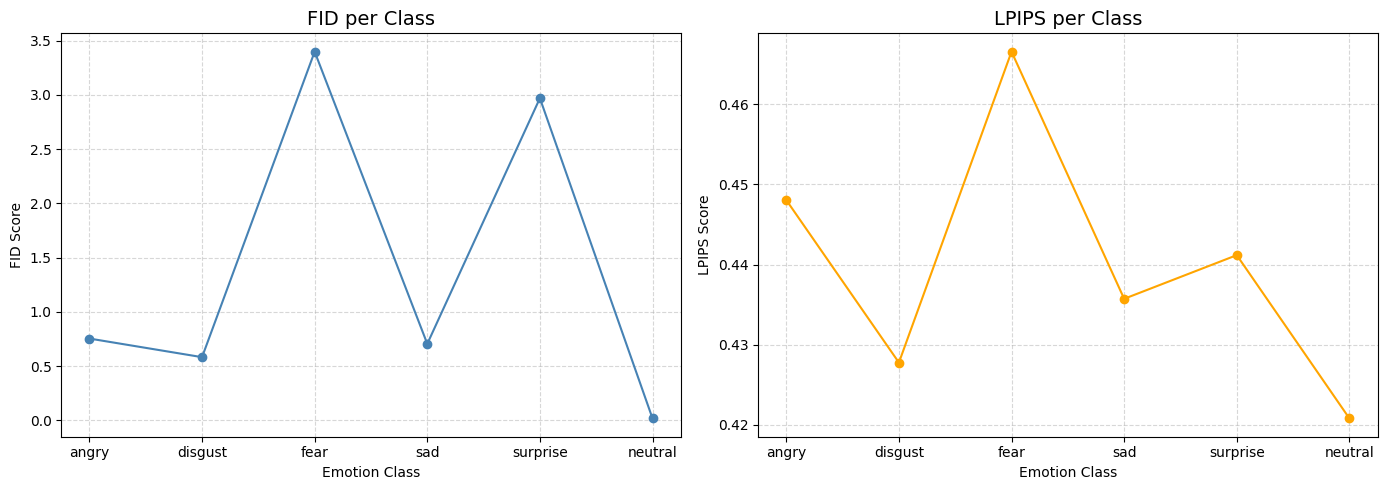

In [ ]:
# Data
classes = ["angry", "disgust", "fear", "sad", "surprise", "neutral"]
x = range(len(classes))
fid_scores = [0.7544, 0.5829, 3.3992, 0.7057, 2.9701, 0.0185]
lpips_scores = [0.448037, 0.427778, 0.466546, 0.435730, 0.441174, 0.420819]

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# FID plot
ax1.plot(classes, fid_scores, marker='o', color='steelblue')
ax1.set_title("FID per Class", fontsize=14)
ax1.set_xlabel("Emotion Class")
ax1.set_ylabel("FID Score")
ax1.grid(True, linestyle='--', alpha=0.5)

# LPIPS plot
ax2.plot(classes, lpips_scores, marker='o', color='orange')
ax2.set_title("LPIPS per Class", fontsize=14)
ax2.set_xlabel("Emotion Class")
ax2.set_ylabel("LPIPS Score")
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


***Show generated image***

In [ ]:
def show_generated_images_by_class(generated_base_path="/content/generated_images",
                                    emotions=None,
                                    images_per_class=4,
                                    image_size=(48, 48)):
    if emotions is None:
        emotions = ['angry', 'disgust','fear','sad', 'surprise','neutral']

    fig, axs = plt.subplots(images_per_class, len(emotions), figsize=(len(emotions) * 1.5, images_per_class * 1.5))

    for col, emotion in enumerate(emotions):
        class_dir = os.path.join(generated_base_path, emotion)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        selected_files = random.sample(image_files, images_per_class)

        for row in range(images_per_class):
            img_path = os.path.join(class_dir, selected_files[row])
            img = Image.open(img_path).convert("L").resize(image_size)
            axs[row, col].imshow(img, cmap='gray')
            axs[row, col].axis('off')

        # Label at the top of each column
        axs[0, col].set_title(emotion.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()

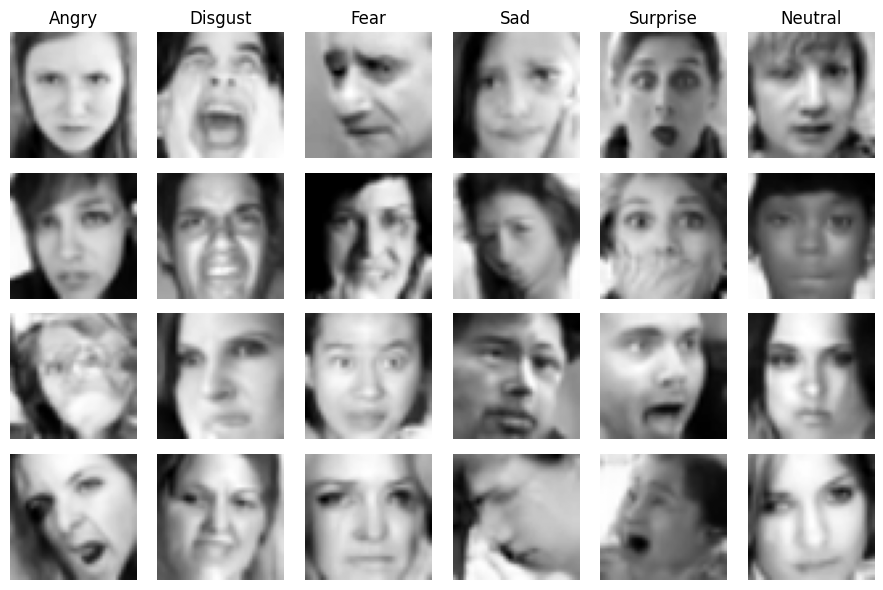

In [ ]:
show_generated_images_by_class(generated_base_path="/content/generated_images")

# Classifiers

## Prepare The Data

    dataset/
      train/
        class1/
        class2/
        ...
      val/
        class1/
        class2/
        ...


In [19]:
zip_path = '/content/generated_data.zip'       # Path to your zip file
extract_dir = 'extracted_dataset'   # Destination directory
os.makedirs(extract_dir, exist_ok=True)

# === UNZIP ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Unzipped '{zip_path}' to '{extract_dir}'")


✅ Unzipped '/content/generated_data.zip' to 'extracted_dataset'


In [20]:

# === CONFIG ===
original_dataset_dir = '/content/extracted_dataset/generated_data'  # Path to original images (class folders)
target_dataset_dir = 'dataset'                                      # Output root folder
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure split directories exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(target_dataset_dir, split), exist_ok=True)

# === PROCESS EACH CLASS ===
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Copy to each split directory
    for split_name, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in tqdm(split_images, desc=f"{split_name}/{class_name}"):
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\n✅ Dataset split into 70% train, 15% val, 15% test.")

test/neutral: 100%|██████████| 6/6 [00:00<00:00, 7612.17it/s]


✅ Dataset split into 70% train, 15% val, 15% test.


In [22]:
# Paths
original_train_dir = '/content/fer2013/train'
original_test_dir = '/content/fer2013/test'
target_dataset_dir = 'dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Split ratios must sum to 1."

# Ensure target directories exist
for split in ['train', 'val', 'test']:
    split_path = os.path.join(target_dataset_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Function to collect all images from a directory
def collect_images(base_dir):
    all_images = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if class_name not in all_images:
            all_images[class_name] = []
        all_images[class_name].extend([os.path.join(class_path, img) for img in images])

    return all_images

# Collect images from both train and test
images_from_train = collect_images(original_train_dir)
images_from_test = collect_images(original_test_dir)

# Merge images from both
all_images = {}
for class_name in set(images_from_train.keys()).union(images_from_test.keys()):
    all_images[class_name] = []
    all_images[class_name].extend(images_from_train.get(class_name, []))
    all_images[class_name].extend(images_from_test.get(class_name, []))

# Split and copy
for class_name, images in all_images.items():
    random.shuffle(images)
    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for src_path in tqdm(split_images, desc=f"{split}/{class_name}"):
            img_name = os.path.basename(src_path)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\nDataset from both train and test folders combined and split into train, val, and test successfully.")


test/fear: 100%|██████████| 769/769 [00:00<00:00, 14043.35it/s]


Dataset from both train and test folders combined and split into train, val, and test successfully.


In [23]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("/content/dataset/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 4246 images
disgust: 4698 images
fear: 5010 images
happy: 6292 images
sad: 4371 images
surprise: 4081 images
neutral: 4362 images

📈 Visual Representation:
angry   : █████████████████████████████████ 4246
disgust : █████████████████████████████████████ 4698
fear    : ███████████████████████████████████████ 5010
happy   : ██████████████████████████████████████████████████ 6292
sad     : ██████████████████████████████████ 4371
surprise: ████████████████████████████████ 4081
neutral : ██████████████████████████████████ 4362


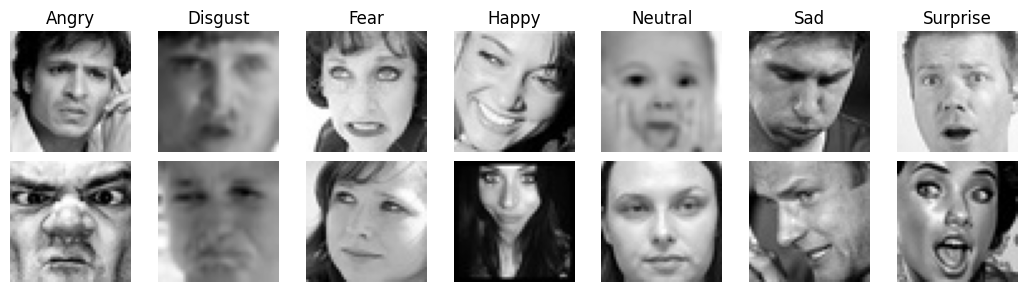

In [24]:
show_emotion_grid("/content/dataset/train")

In [ ]:
# Paths
original_train_dir = '/content/fer2013/train'
original_test_dir = '/content/fer2013/test'
target_dataset_dir = 'original_dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Split ratios must sum to 1."

# Ensure target directories exist
for split in ['train', 'val', 'test']:
    split_path = os.path.join(target_dataset_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Function to collect all images from a directory
def collect_images(base_dir):
    all_images = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if class_name not in all_images:
            all_images[class_name] = []
        all_images[class_name].extend([os.path.join(class_path, img) for img in images])

    return all_images

# Collect images from both train and test
images_from_train = collect_images(original_train_dir)
images_from_test = collect_images(original_test_dir)

# Merge images from both
all_images = {}
for class_name in set(images_from_train.keys()).union(images_from_test.keys()):
    all_images[class_name] = []
    all_images[class_name].extend(images_from_train.get(class_name, []))
    all_images[class_name].extend(images_from_test.get(class_name, []))

# Split and copy
for class_name, images in all_images.items():
    random.shuffle(images)
    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for src_path in tqdm(split_images, desc=f"{split}/{class_name}"):
            img_name = os.path.basename(src_path)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\nDataset from both train and test folders combined and split into train, val, and test successfully.")


test/angry: 100%|██████████| 744/744 [00:00<00:00, 15422.37it/s]


Dataset from both train and test folders combined and split into train, val, and test successfully.


In [ ]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("/content/original_dataset/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 3467 images
disgust: 382 images
fear: 3584 images
happy: 6292 images
sad: 4253 images
surprise: 2801 images
neutral: 4338 images

📈 Visual Representation:
angry   : ███████████████████████████ 3467
disgust : ███ 382
fear    : ████████████████████████████ 3584
happy   : ██████████████████████████████████████████████████ 6292
sad     : █████████████████████████████████ 4253
surprise: ██████████████████████ 2801
neutral : ██████████████████████████████████ 4338


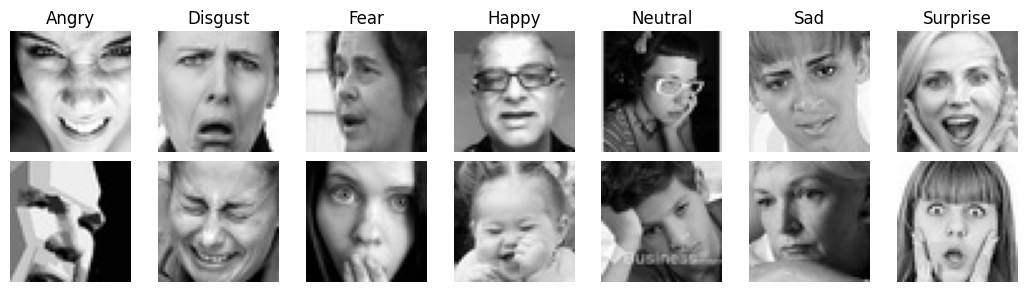

In [ ]:
show_emotion_grid("/content/original_dataset/train")

## CNN

**CNN ARCH**

In [25]:
# === MODEL ===
class MultiClassCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


**Training CONFIG**

In [26]:
# === CONFIG ===

batch_size = 64
num_epochs = 100
learning_rate = 0.001


**Training Loop Function**

In [27]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        print(f"\n🌱 Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            loader = train_loader if phase == 'train' else val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(loader, desc=f"{phase.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    print("\n✅ Training complete.")


**Testing Function**

In [28]:
def test_model(model, test_loader, criterion, device):
    print("\n🧪 Starting test phase...")
    model.eval()
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Test"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += (preds == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects / len(test_loader.dataset)

    print(f"\n📊 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


In [29]:
def evaluate_model(model, test_loader, device, class_names):
    print("\n🧪 Starting evaluation phase...")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === METRICS ===
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n🔍 Test Accuracy: {acc:.4f}")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, cm


### CNN (GENERATED + REAL)

In [30]:
# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

data_dir = 'dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)

🔢 Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🔢 Class-to-index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
🔢 Number of classes: 7


**Create Model**

In [31]:
cnn_generated_model = MultiClassCNN(num_classes).to(device)

# === LOSS & OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_generated_model.parameters(), lr=learning_rate)


**Training**

In [ ]:
train_and_validate(
    model=cnn_generated_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)


🌱 Epoch 1/100


Train: 100%|██████████| 517/517 [00:18<00:00, 27.72it/s]


Train Loss: 1.6346 | Acc: 0.3592


Val: 100%|██████████| 111/111 [00:03<00:00, 32.88it/s]


Val Loss: 1.3808 | Acc: 0.4744

🌱 Epoch 2/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.44it/s]


Train Loss: 1.3542 | Acc: 0.4828


Val: 100%|██████████| 111/111 [00:03<00:00, 33.49it/s]


Val Loss: 1.2857 | Acc: 0.5069

🌱 Epoch 3/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.51it/s]


Train Loss: 1.2568 | Acc: 0.5205


Val: 100%|██████████| 111/111 [00:03<00:00, 33.50it/s]


Val Loss: 1.2281 | Acc: 0.5405

🌱 Epoch 4/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.58it/s]


Train Loss: 1.1901 | Acc: 0.5460


Val: 100%|██████████| 111/111 [00:03<00:00, 33.46it/s]


Val Loss: 1.1935 | Acc: 0.5456

🌱 Epoch 5/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.53it/s]


Train Loss: 1.1267 | Acc: 0.5708


Val: 100%|██████████| 111/111 [00:03<00:00, 33.24it/s]


Val Loss: 1.1350 | Acc: 0.5684

🌱 Epoch 6/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.30it/s]


Train Loss: 1.0781 | Acc: 0.5899


Val: 100%|██████████| 111/111 [00:03<00:00, 33.42it/s]


Val Loss: 1.1171 | Acc: 0.5801

🌱 Epoch 7/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.62it/s]


Train Loss: 1.0229 | Acc: 0.6126


Val: 100%|██████████| 111/111 [00:03<00:00, 33.41it/s]


Val Loss: 1.1155 | Acc: 0.5823

🌱 Epoch 8/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.68it/s]


Train Loss: 0.9759 | Acc: 0.6273


Val: 100%|██████████| 111/111 [00:03<00:00, 33.57it/s]


Val Loss: 1.1133 | Acc: 0.5816

🌱 Epoch 9/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.67it/s]


Train Loss: 0.9222 | Acc: 0.6468


Val: 100%|██████████| 111/111 [00:03<00:00, 33.56it/s]


Val Loss: 1.1260 | Acc: 0.5850

🌱 Epoch 10/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.59it/s]


Train Loss: 0.8726 | Acc: 0.6642


Val: 100%|██████████| 111/111 [00:03<00:00, 33.69it/s]


Val Loss: 1.1469 | Acc: 0.5870

🌱 Epoch 11/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.76it/s]


Train Loss: 0.8283 | Acc: 0.6809


Val: 100%|██████████| 111/111 [00:03<00:00, 33.46it/s]


Val Loss: 1.2010 | Acc: 0.5814

🌱 Epoch 12/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.77it/s]


Train Loss: 0.7821 | Acc: 0.6950


Val: 100%|██████████| 111/111 [00:03<00:00, 33.46it/s]


Val Loss: 1.1855 | Acc: 0.5838

🌱 Epoch 13/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.67it/s]


Train Loss: 0.7377 | Acc: 0.7126


Val: 100%|██████████| 111/111 [00:03<00:00, 33.45it/s]


Val Loss: 1.2231 | Acc: 0.5863

🌱 Epoch 14/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.63it/s]


Train Loss: 0.6972 | Acc: 0.7270


Val: 100%|██████████| 111/111 [00:03<00:00, 33.44it/s]


Val Loss: 1.3122 | Acc: 0.5880

🌱 Epoch 15/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.44it/s]


Train Loss: 0.6632 | Acc: 0.7409


Val: 100%|██████████| 111/111 [00:03<00:00, 33.69it/s]


Val Loss: 1.3498 | Acc: 0.5805

🌱 Epoch 16/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.47it/s]


Train Loss: 0.6340 | Acc: 0.7509


Val: 100%|██████████| 111/111 [00:03<00:00, 33.57it/s]


Val Loss: 1.3658 | Acc: 0.5849

🌱 Epoch 17/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.54it/s]


Train Loss: 0.6004 | Acc: 0.7645


Val: 100%|██████████| 111/111 [00:03<00:00, 33.28it/s]


Val Loss: 1.4231 | Acc: 0.5856

🌱 Epoch 18/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.79it/s]


Train Loss: 0.5714 | Acc: 0.7755


Val: 100%|██████████| 111/111 [00:03<00:00, 33.62it/s]


Val Loss: 1.5285 | Acc: 0.5855

🌱 Epoch 19/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.57it/s]


Train Loss: 0.5412 | Acc: 0.7880


Val: 100%|██████████| 111/111 [00:03<00:00, 33.63it/s]


Val Loss: 1.5701 | Acc: 0.5777

🌱 Epoch 20/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.50it/s]


Train Loss: 0.5132 | Acc: 0.7970


Val: 100%|██████████| 111/111 [00:03<00:00, 33.44it/s]


Val Loss: 1.5292 | Acc: 0.5799

🌱 Epoch 21/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.58it/s]


Train Loss: 0.5024 | Acc: 0.8011


Val: 100%|██████████| 111/111 [00:03<00:00, 33.24it/s]


Val Loss: 1.6708 | Acc: 0.5818

🌱 Epoch 22/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.61it/s]


Train Loss: 0.4859 | Acc: 0.8094


Val: 100%|██████████| 111/111 [00:03<00:00, 33.65it/s]


Val Loss: 1.7055 | Acc: 0.5804

🌱 Epoch 23/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.50it/s]


Train Loss: 0.4634 | Acc: 0.8145


Val: 100%|██████████| 111/111 [00:03<00:00, 33.48it/s]


Val Loss: 1.8130 | Acc: 0.5678

🌱 Epoch 24/100


Train: 100%|██████████| 517/517 [00:17<00:00, 29.60it/s]


Train Loss: 0.4488 | Acc: 0.8217


Val: 100%|██████████| 111/111 [00:03<00:00, 33.66it/s]


Val Loss: 1.7657 | Acc: 0.5768

🌱 Epoch 25/100


Train:  39%|███▉      | 202/517 [00:06<00:10, 29.72it/s]

**Testing and Evaluating**

In [ ]:
test_loss, test_acc = test_model(
    model=cnn_generated_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=cnn_generated_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

### CNN (Real)

In [ ]:
# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

data_dir = 'original_dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)

**Create Model**

In [ ]:
cnn_real_model = MultiClassCNN(num_classes).to(device)

# === LOSS & OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_real_model.parameters(), lr=learning_rate)


**Training**

In [ ]:
train_and_validate(
    model=cnn_real_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

**Testing and Evaluating**

In [ ]:
test_loss, test_acc = test_model(
    model=cnn_real_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=cnn_real_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

## ResNet Classifiers Experements

In [ ]:
# === CONFIG ===

batch_size = 64
num_epochs = 100
learning_rate = 0.001


In [ ]:
def train_with_early_stopping_resnet(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, patience=10, save_path="best_model.pth"):
    best_val_acc = 0.0
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # === Training Phase ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # === Validation Phase ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # === Early Stopping Check ===
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            print(f"🔴 No improvement. Early stopping patience counter: {counter}/{patience}")
            if counter >= patience:
                print("🚨 Early stopping triggered.")
                break

    # === Load Best Model & Save ===
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    print(f"\n✅ Training complete. Best val accuracy: {best_val_acc:.4f}")

    return model, best_val_acc


In [ ]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                    # Convert to 3 channels for ResNet
    transforms.Resize((224, 224)),                                  # Resize to ResNet input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# === For validation/testing ===
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

### Original Dataset

In [ ]:
data_dir = 'original_dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)


# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)


In [ ]:
# Define model (ResNet18)
resnet_original_data_model = models.resnet18(pretrained=True)
resnet_original_data_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet_original_data_model.fc.in_features, 7)
)

resnet_original_data_model = resnet_original_data_model.to(device)

# Loss and optimizer
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(resnet_original_data_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [ ]:
resnet_original_data_model, best_val_acc = train_with_early_stopping_resnet(
    model=resnet_original_data_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=10,
    save_path="best_resnet_original_data_model.pth"
)

In [ ]:
test_loss, test_acc = test_model(
    model=resnet_original_data_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=resnet_original_data_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

### Aug Data

In [ ]:
data_dir = 'dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)


# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)


🔢 Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🔢 Class-to-index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
🔢 Number of classes: 7


In [ ]:
# Define model (ResNet18)
resnet_data_model = models.resnet18(pretrained=True)
resnet_data_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet_data_model.fc.in_features, 7)
)

resnet_data_model = resnet_data_model.to(device)

# Loss and optimizer
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(resnet_data_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
resnet_data_model, best_val_acc = train_with_early_stopping_resnet(
    model=resnet_data_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=10,
    save_path="best_resnet_data_model.pth"
)


Epoch 1/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.85it/s]


Train Loss: 1.3907 | Train Acc: 0.5353
Val Loss: 1.3807 | Val Acc: 0.5634

Epoch 2/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.68it/s]


Train Loss: 1.2617 | Train Acc: 0.5991
Val Loss: 1.2734 | Val Acc: 0.5883

Epoch 3/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.84it/s]


Train Loss: 1.2267 | Train Acc: 0.6163
Val Loss: 1.2514 | Val Acc: 0.6028

Epoch 4/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 1.2038 | Train Acc: 0.6288
Val Loss: 1.2072 | Val Acc: 0.6236

Epoch 5/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]


Train Loss: 1.1904 | Train Acc: 0.6352
Val Loss: 1.1904 | Val Acc: 0.6376

Epoch 6/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]


Train Loss: 1.1808 | Train Acc: 0.6408
Val Loss: 1.1949 | Val Acc: 0.6363
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 7/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]


Train Loss: 1.1651 | Train Acc: 0.6484
Val Loss: 1.1720 | Val Acc: 0.6472

Epoch 8/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.89it/s]


Train Loss: 1.1518 | Train Acc: 0.6546
Val Loss: 1.1853 | Val Acc: 0.6370
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 9/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.97it/s]


Train Loss: 1.1363 | Train Acc: 0.6616
Val Loss: 1.1627 | Val Acc: 0.6500

Epoch 10/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.95it/s]


Train Loss: 1.1263 | Train Acc: 0.6677
Val Loss: 1.1526 | Val Acc: 0.6578

Epoch 11/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]


Train Loss: 1.1138 | Train Acc: 0.6733
Val Loss: 1.1740 | Val Acc: 0.6452
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 12/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 1.1031 | Train Acc: 0.6805
Val Loss: 1.1509 | Val Acc: 0.6551
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 13/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.78it/s]


Train Loss: 1.0878 | Train Acc: 0.6853
Val Loss: 1.1304 | Val Acc: 0.6631

Epoch 14/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 1.0777 | Train Acc: 0.6926
Val Loss: 1.1379 | Val Acc: 0.6650

Epoch 15/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]


Train Loss: 1.0706 | Train Acc: 0.6994
Val Loss: 1.1455 | Val Acc: 0.6641
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 16/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]


Train Loss: 1.0631 | Train Acc: 0.7021
Val Loss: 1.1301 | Val Acc: 0.6686

Epoch 17/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 1.0507 | Train Acc: 0.7056
Val Loss: 1.1347 | Val Acc: 0.6667
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 18/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]


Train Loss: 1.0439 | Train Acc: 0.7127
Val Loss: 1.1345 | Val Acc: 0.6684
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 19/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.04it/s]


Train Loss: 1.0312 | Train Acc: 0.7164
Val Loss: 1.1240 | Val Acc: 0.6766

Epoch 20/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]


Train Loss: 1.0257 | Train Acc: 0.7237
Val Loss: 1.1385 | Val Acc: 0.6709
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 21/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.84it/s]


Train Loss: 1.0167 | Train Acc: 0.7283
Val Loss: 1.1590 | Val Acc: 0.6637
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 22/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]


Train Loss: 1.0113 | Train Acc: 0.7307
Val Loss: 1.1202 | Val Acc: 0.6831

Epoch 23/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 1.0049 | Train Acc: 0.7328
Val Loss: 1.1156 | Val Acc: 0.6804
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 24/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.87it/s]


Train Loss: 0.9980 | Train Acc: 0.7349
Val Loss: 1.1337 | Val Acc: 0.6692
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 25/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.88it/s]


Train Loss: 0.9896 | Train Acc: 0.7414
Val Loss: 1.1354 | Val Acc: 0.6770
🔴 No improvement. Early stopping patience counter: 3/10

Epoch 26/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.96it/s]


Train Loss: 0.9883 | Train Acc: 0.7425
Val Loss: 1.1180 | Val Acc: 0.6816
🔴 No improvement. Early stopping patience counter: 4/10

Epoch 27/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.88it/s]


Train Loss: 0.9806 | Train Acc: 0.7470
Val Loss: 1.1345 | Val Acc: 0.6695
🔴 No improvement. Early stopping patience counter: 5/10

Epoch 28/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.94it/s]


Train Loss: 0.9712 | Train Acc: 0.7496
Val Loss: 1.1743 | Val Acc: 0.6688
🔴 No improvement. Early stopping patience counter: 6/10

Epoch 29/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]


Train Loss: 0.9657 | Train Acc: 0.7545
Val Loss: 1.1256 | Val Acc: 0.6757
🔴 No improvement. Early stopping patience counter: 7/10

Epoch 30/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]


Train Loss: 0.9036 | Train Acc: 0.7872
Val Loss: 1.1053 | Val Acc: 0.6976

Epoch 31/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 0.8789 | Train Acc: 0.7981
Val Loss: 1.1133 | Val Acc: 0.7001

Epoch 32/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 0.8670 | Train Acc: 0.8035
Val Loss: 1.1102 | Val Acc: 0.7008

Epoch 33/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.89it/s]


Train Loss: 0.8514 | Train Acc: 0.8145
Val Loss: 1.1335 | Val Acc: 0.6958
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 34/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 0.8470 | Train Acc: 0.8149
Val Loss: 1.1163 | Val Acc: 0.6946
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 35/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 0.8326 | Train Acc: 0.8225
Val Loss: 1.1266 | Val Acc: 0.7042

Epoch 36/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.85it/s]


Train Loss: 0.8242 | Train Acc: 0.8290
Val Loss: 1.1452 | Val Acc: 0.6895
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 37/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.83it/s]


Train Loss: 0.7816 | Train Acc: 0.8507
Val Loss: 1.1347 | Val Acc: 0.7014
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 38/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 0.7637 | Train Acc: 0.8591
Val Loss: 1.1384 | Val Acc: 0.7068

Epoch 39/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.93it/s]


Train Loss: 0.7465 | Train Acc: 0.8678
Val Loss: 1.1428 | Val Acc: 0.7045
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 40/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 0.7447 | Train Acc: 0.8691
Val Loss: 1.1498 | Val Acc: 0.7083

Epoch 41/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]


Train Loss: 0.7364 | Train Acc: 0.8741
Val Loss: 1.1610 | Val Acc: 0.6994
🔴 No improvement. Early stopping patience counter: 1/10

Epoch 42/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.99it/s]


Train Loss: 0.7244 | Train Acc: 0.8799
Val Loss: 1.1778 | Val Acc: 0.6941
🔴 No improvement. Early stopping patience counter: 2/10

Epoch 43/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]


Train Loss: 0.7010 | Train Acc: 0.8905
Val Loss: 1.1554 | Val Acc: 0.7058
🔴 No improvement. Early stopping patience counter: 3/10

Epoch 44/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.02it/s]


Train Loss: 0.6894 | Train Acc: 0.8965
Val Loss: 1.1667 | Val Acc: 0.7031
🔴 No improvement. Early stopping patience counter: 4/10

Epoch 45/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  6.98it/s]


Train Loss: 0.6865 | Train Acc: 0.8973
Val Loss: 1.1654 | Val Acc: 0.7055
🔴 No improvement. Early stopping patience counter: 5/10

Epoch 46/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.01it/s]


Train Loss: 0.6773 | Train Acc: 0.9035
Val Loss: 1.1684 | Val Acc: 0.7045
🔴 No improvement. Early stopping patience counter: 6/10

Epoch 47/100


Validation: 100%|██████████| 111/111 [00:15<00:00,  7.02it/s]


Train Loss: 0.6735 | Train Acc: 0.9054
Val Loss: 1.1750 | Val Acc: 0.6996
🔴 No improvement. Early stopping patience counter: 7/10

Epoch 48/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]


Train Loss: 0.6653 | Train Acc: 0.9073
Val Loss: 1.1848 | Val Acc: 0.7030
🔴 No improvement. Early stopping patience counter: 8/10

Epoch 49/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.91it/s]


Train Loss: 0.6572 | Train Acc: 0.9121
Val Loss: 1.1754 | Val Acc: 0.7031
🔴 No improvement. Early stopping patience counter: 9/10

Epoch 50/100


Validation: 100%|██████████| 111/111 [00:16<00:00,  6.92it/s]

Train Loss: 0.6516 | Train Acc: 0.9164
Val Loss: 1.1841 | Val Acc: 0.7058
🔴 No improvement. Early stopping patience counter: 10/10
🚨 Early stopping triggered.

✅ Training complete. Best val accuracy: 0.7083



🧪 Starting test phase...


Test: 100%|██████████| 111/111 [00:16<00:00,  6.90it/s]



📊 Test Loss: 1.1446 | Test Accuracy: 0.7055

🧪 Starting evaluation phase...


Testing: 100%|██████████| 111/111 [00:16<00:00,  6.90it/s]



🔍 Test Accuracy: 0.7055

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.52      0.56       912
     disgust       0.83      0.90      0.86      1009
        fear       0.59      0.52      0.55      1076
       happy       0.86      0.87      0.86      1349
     neutral       0.65      0.63      0.64       937
         sad       0.55      0.65      0.59       940
    surprise       0.79      0.78      0.78       876

    accuracy                           0.71      7099
   macro avg       0.70      0.70      0.69      7099
weighted avg       0.70      0.71      0.70      7099



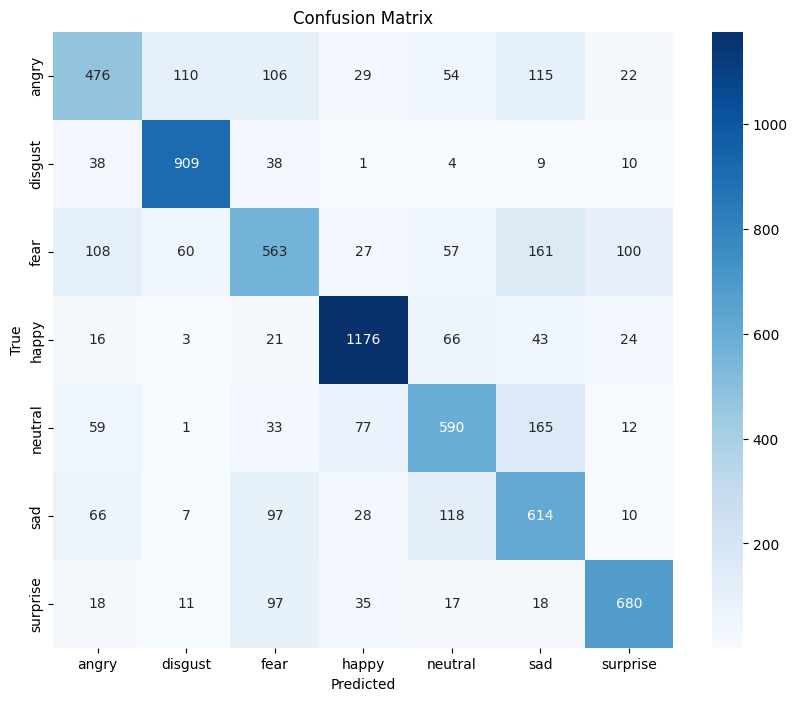

In [ ]:
test_loss, test_acc = test_model(
    model=resnet_data_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=resnet_data_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)